# Model 2: CNNs-with-Aug

## 13-Layer CNN With Data Augmentation

**Architecture:** Same 13-layer CNN as Model 1
**Key Difference:** Uses data augmentation + 128×128 input

**Hyperparameters:**
- Input: 128×128×3
- Epochs: 100, Batch: 65, LR: 0.0001
- WITH data augmentation (rotation, flip, zoom, shift)

**Target:** 99.61% accuracy

In [1]:
%run 00_utils_and_config.ipynb

PyTorch version: 2.9.1+cu130
CUDA available: True
CUDA version: 13.0
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Device: cuda
Configuration loaded successfully!

Base path: C:\Users\rishi\CV_Assignment\Paper2
Raw data path: C:\Users\rishi\CV_Assignment\Paper2\Raw_Data
Number of models: 5
Data processing functions loaded successfully!
Evaluation metrics functions loaded successfully!
Visualization functions loaded successfully!
Data augmentation setup loaded successfully!

PAPER 2 UTILITIES AND CONFIGURATION - SUMMARY

✓ All libraries imported successfully
✓ Configuration parameters loaded
✓ Data processing functions defined
✓ Evaluation metrics functions defined
✓ Visualization functions defined
✓ Data augmentation configured

Ready to proceed with:
  - Notebook 01: Data Preparation
  - Notebooks 02-06: Model Implementations
  - Notebook 07: Results Comparison



## 1. Load Data (128×128)

In [2]:
data_path = CONFIG["processed_data_path"]

print("Loading 128×128 data...")
X_train = np.load(data_path / "X_train_128.npy")
X_test = np.load(data_path / "X_test_128.npy")
y_train = np.load(data_path / "y_train.npy")
y_test = np.load(data_path / "y_test.npy")

X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

# Convert to PyTorch format (N, C, H, W)
X_train = np.transpose(X_train, (0, 3, 1, 2))
X_test = np.transpose(X_test, (0, 3, 1, 2))

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")

Loading 128×128 data...
X_train: (4374, 3, 128, 128), X_test: (1094, 3, 128, 128)


## 2. Build Model (Same as Model 1, Different Input Size)

In [3]:
model_config = CONFIG["models"]["cnn_with_aug"]

class CNNWithAug(nn.Module):
    def __init__(self, input_channels=3, num_classes=2):
        super(CNNWithAug, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.20)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)
        self.flatten_size = 64 * 16 * 16  # 128->64->32->16
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.dropout1(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.dropout2(x)
        x = x.view(-1, self.flatten_size)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CNNWithAug(input_channels=3, num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

CNNWithAug(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)
Total parameters: 2,129,250


## 3. Setup Data Augmentation

In [4]:
# Create augmented datasets
train_transforms, test_transforms = create_data_augmentation()
train_dataset = AugmentedDataset(X_train, y_train, transform=train_transforms)
test_dataset = AugmentedDataset(X_test, y_test, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=65, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=65, shuffle=False)

print("✓ Data augmentation configured and DataLoaders created")

✓ Data augmentation configured and DataLoaders created


## 4. Train with Augmentation

In [5]:
start_time = time.time()
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0.0
best_model_path = str(CONFIG["saved_models_path"] / "model2_cnn_with_aug_best.pth")

for epoch in range(100):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / total
    train_acc = correct / total
    
    # Validate
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss /= val_total
    val_acc = val_correct / val_total
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"Epoch {epoch+1}/100 - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} ✓")
    elif (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/100 - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

training_time = time.time() - start_time
print(f"Training time: {training_time:.1f}s")

Epoch 1/100 - Loss: 0.6887, Acc: 0.5466, Val Loss: 0.6900, Val Acc: 0.5512 ✓
Epoch 3/100 - Loss: 0.6851, Acc: 0.5508, Val Loss: 0.6874, Val Acc: 0.5640 ✓
Epoch 5/100 - Loss: 0.6820, Acc: 0.5560, Val Loss: 0.6764, Val Acc: 0.5713 ✓
Epoch 7/100 - Loss: 0.6713, Acc: 0.5796, Val Loss: 0.6655, Val Acc: 0.6298 ✓
Epoch 10/100 - Loss: 0.6687, Acc: 0.5841, Val Loss: 0.6620, Val Acc: 0.6152
Epoch 17/100 - Loss: 0.6581, Acc: 0.6017, Val Loss: 0.6524, Val Acc: 0.6371 ✓
Epoch 18/100 - Loss: 0.6568, Acc: 0.6116, Val Loss: 0.6515, Val Acc: 0.6417 ✓
Epoch 20/100 - Loss: 0.6582, Acc: 0.6150, Val Loss: 0.6536, Val Acc: 0.6261
Epoch 30/100 - Loss: 0.6501, Acc: 0.6246, Val Loss: 0.6467, Val Acc: 0.6216
Epoch 37/100 - Loss: 0.6430, Acc: 0.6328, Val Loss: 0.6405, Val Acc: 0.6426 ✓
Epoch 39/100 - Loss: 0.6441, Acc: 0.6296, Val Loss: 0.6371, Val Acc: 0.6490 ✓
Epoch 40/100 - Loss: 0.6414, Acc: 0.6276, Val Loss: 0.6363, Val Acc: 0.6380
Epoch 44/100 - Loss: 0.6359, Acc: 0.6440, Val Loss: 0.6344, Val Acc: 0.6508 

## 5. Evaluate

In [6]:
best_model = CNNWithAug(input_channels=3, num_classes=2).to(device)
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()

start_time = time.time()
all_preds, all_probs = [], []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = best_model(inputs)
        probs = F.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())
        _, predicted = torch.max(outputs.data, 1)
        all_preds.append(predicted.cpu().numpy())

y_pred_proba = np.vstack(all_probs)
y_pred = np.concatenate(all_preds)
testing_time = (time.time() - start_time) * 1000

metrics = calculate_all_metrics(y_test, y_pred, y_pred_proba[:, 1])
print_metrics(metrics, "Model 2: CNNs-with-Aug")
print(f"Testing time: {testing_time:.1f}ms")


Model 2: CNNs-with-Aug - Evaluation Metrics
Accuracy:    66.64%
Precision:   69.69%
Recall:      45.42%
F1-Score:    54.99%
Specificity: 83.91%
AUC:         0.7477

Confusion Matrix:
  TN=506, FP=97
  FN=268, TP=223

Testing time: 649.0ms


## 6. Visualize

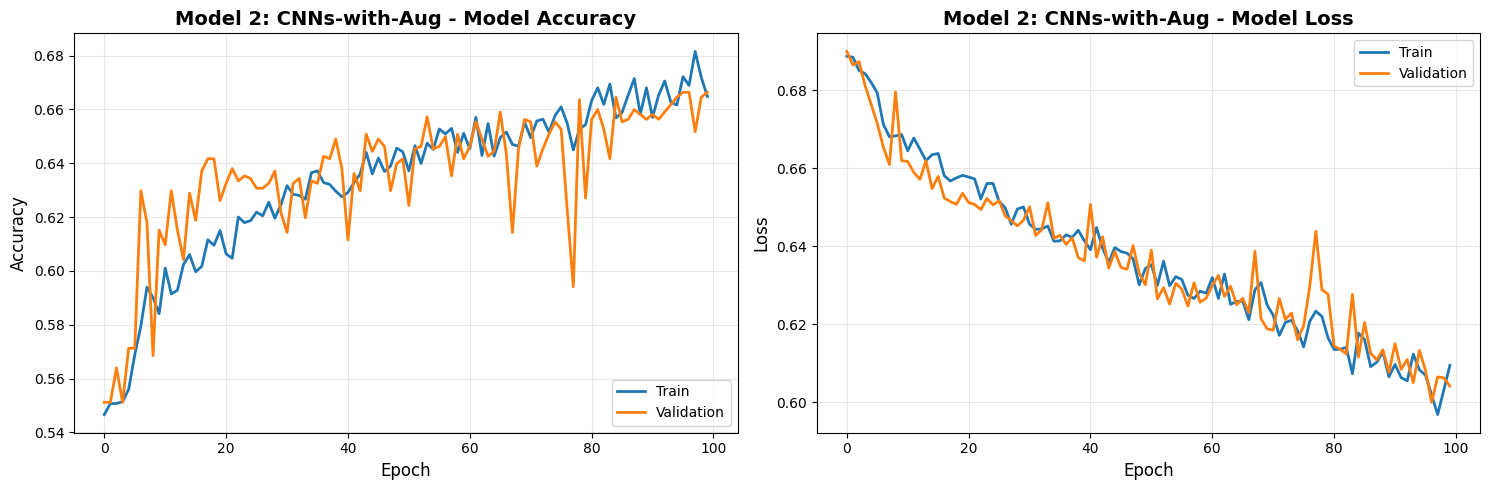

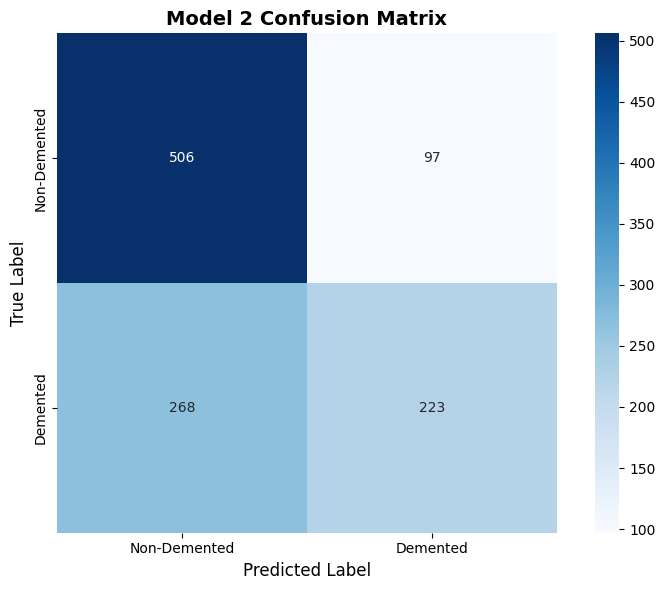

In [7]:
plot_training_history(history, "Model 2: CNNs-with-Aug", CONFIG["results_path"] / "training_curves" / "model2_training.png")
plot_confusion_matrix(metrics["confusion_matrix"], CONFIG["class_names"], "Model 2 Confusion Matrix", CONFIG["results_path"] / "confusion_matrices" / "model2_cm.png")

## 7. Save Results

In [ ]:
results = {
    "model_name": "CNNs-with-Aug",
    "accuracy": float(metrics["accuracy"]),
    "precision": float(metrics["precision"]),
    "recall": float(metrics["recall"]),
    "f1_score": float(metrics["f1_score"]),
    "specificity": float(metrics["specificity"]),
    "training_time_seconds": float(training_time),
    "testing_time_ms": float(testing_time)
}

torch.save(model.state_dict(), CONFIG["saved_models_path"] / "model2_cnn_with_aug_final.pth")

with open(CONFIG["results_path"] / "model2_results.json", "w") as f:
    json.dump(results, f, indent=2)

print(f"\n✓ Accuracy: {metrics['accuracy']*100:.2f}% (Target: 99.61%)")


✓ Accuracy: 66.64% (Target: 99.61%)


: 